# Simulation of Audio-Visual Duration Estimation with Causal Inference Model
This notebook simulates the audio-visual duration estimation task using a causal inference model. It allows you to explore how different parameters affect the estimates through interactive controls.
### Experimenter knows the true durations:
Standard duration($S_s$) is always 0.5s, test duration varies($S_t$).
We simulate and give the parameters to the model, and see how the estimates change.
Parameters:
- $\sigma_a$: Standard deviation of auditory measurement noise
- $\sigma_v$: Standard deviation of visual measurement noise
- $p_c$: Prior probability of common cause
### Parameters we dont need to adjust specifically:
- $c$: Conflict level between auditory and visual stimuli
- $tmin$ and $tmax$: Minimum and maximum test durations

### Steps:
1. Create and repeated array of standard durations: S_s: [0.5, 0.5, ..., 0.5]
2. Create an array of duration differences: delta: [0.0, 0.1, ..., 2.0]
3. Create constant conflict durations: c:[-250,-167,-83,0,83,167,250]ms
4. For each combination of S_s, delta, and c:
    - Calculate test duration: S_t = S_s + delta + c
5. For simplicity we dont need to estimate noisy measurements, we can directly use the true durations as measurements.
6. Use the causal inference model to compute the final estimates based on the measurements and parameters.


In [39]:
# import lbraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, gaussian_kde
from ipywidgets import interact, FloatSlider, widgets
from scipy.special import expit  # Sigmoid function for probability mapping
import warnings


In [40]:
## Simulation of Audio-Visual Duration Estimation with Causal Inference Model This notebook simulates the audio-visual duration estimation task using a causal inference model. It allows you to explore how different parameters affect the estimates through interactive controls. ### Experimenter knows the true durations: Standard duration($S_s$) is always 0.5s, test duration varies($S_t$). We simulate and give the parameters to the model, and see how the estimates change. Parameters: - $\sigma_a$: Standard deviation of auditory measurement noise - $\sigma_v$: Standard deviation of visual measurement noise - $p_c$: Prior probability of common cause ### Parameters we dont need to adjust specifically: - $c$: Conflict level between auditory and visual stimuli - $\tmin$ and $\tmax$: Minimum and maximum test durations ### Steps: 1. Create and repeated array of standard durations: S_s: [0.5, 0.5, ..., 0.5] 2. Create an array of duration differences: delta: [0.0, 0.1, ..., 2.0] 3. Create constant conflict durations: c:[-250,-167,-83,0,83,167,250]ms 4. For each combination of S_s, delta, and c: - Calculate test duration: S_t = S_s + delta + c 5. For simplicity we dont need to estimate noisy measurements, we can directly use the true durations as measurements. 6. Use the causal inference model to compute the final estimates based on the measurements and parameters.
# Standard durations of auditory stimuli
S_a_s = 0.5  # seconds
# repeat
S_a_s = np.repeat(S_a_s, 9990)
# Range of test durations (difference from standard) -100% to +100%
delta_percent = np.linspace(-0.95, 0.95, 7)  # -100% to +100%
# Convert percentage differences to absolute time differences (in seconds)
delta = delta_percent * S_a_s[0]  # since S_a_s is constant
# Constant conflict levels (in seconds)
c = np.array([-0.45,-0.35, -0.25, -0.167, -0.083, 0.0, 0.083, 0.167, 0.25, 0.35,+0.45])  # seconds

# Ensure all arrays have the same length
min_length = min(len(S_a_s), len(delta) * (len(S_a_s) // len(delta)), len(c) * (len(S_a_s) // len(c)))
S_a_s = S_a_s[:min_length]
delta = np.tile(delta, int(np.ceil(len(S_a_s) / len(delta))))[:min_length]
c = np.tile(c, int(np.ceil(len(S_a_s) / len(c))))[:min_length]

# Calculate test durations
S_a_t = S_a_s + delta 
S_v_s = S_a_s + c  # Visual test durations with conflict
S_v_t = S_a_t # no conflict in test durations for visual
# Combine standard and test durations, delta, and conflict into a single dataset
simData=np.column_stack((S_a_s, S_a_t, S_v_s, S_v_t, delta, c))
# Columns: [S_a_s, S_a_t, S_v_s, S_v_t, delta, c]

# create a dataframe
import pandas as pd
simData = pd.DataFrame(simData, columns=['S_a_s', 'S_a_t', 'S_v_s', 'S_v_t', 'delta', 'c'])





In [41]:
simData

,S_a_s,S_a_t,S_v_s,S_v_t,delta,c
0,0.5,0.025000,0.050,0.025000,-0.475000,-0.450
1,0.5,0.183333,0.150,0.183333,-0.316667,-0.350
2,0.5,0.341667,0.250,0.341667,-0.158333,-0.250
3,0.5,0.500000,0.333,0.500000,0.000000,-0.167
4,0.5,0.658333,0.417,0.658333,0.158333,-0.083
...,...,...,...,...,...,...
9983,0.5,0.183333,0.583,0.183333,-0.316667,0.083
9984,0.5,0.341667,0.667,0.341667,-0.158333,0.167
9985,0.5,0.500000,0.750,0.500000,0.000000,0.250
9986,0.5,0.658333,0.850,0.658333,0.158333,0.350


In [42]:
# Check for potential issues with negative durations
print("Data summary:")
print(f"S_a_t min: {simData['S_a_t'].min():.3f}, max: {simData['S_a_t'].max():.3f}")
print(f"S_v_t min: {simData['S_v_t'].min():.3f}, max: {simData['S_v_t'].max():.3f}")
print(f"S_v_s min: {simData['S_v_s'].min():.3f}, max: {simData['S_v_s'].max():.3f}")

# Check if any values are negative or zero
negative_Sa_t = simData[simData['S_a_t'] <= 0]
negative_Sv_t = simData[simData['S_v_t'] <= 0] 
negative_Sv_s = simData[simData['S_v_s'] <= 0]

print(f"\nNegative/zero durations:")
print(f"S_a_t <= 0: {len(negative_Sa_t)} cases")
print(f"S_v_t <= 0: {len(negative_Sv_t)} cases") 
print(f"S_v_s <= 0: {len(negative_Sv_s)} cases")

if len(negative_Sv_s) > 0:
    print(f"Example negative S_v_s: {negative_Sv_s[['S_v_s', 'c']].head()}")

Data summary:
S_a_t min: 0.025, max: 0.975
S_v_t min: 0.025, max: 0.975
S_v_s min: 0.050, max: 0.950

Negative/zero durations:
S_a_t <= 0: 0 cases
S_v_t <= 0: 0 cases
S_v_s <= 0: 0 cases


In [51]:
# --- FUSION MODEL IMPLEMENTATION ---
def fusion_estimate(m_a, m_v, sigma_a, sigma_v):
    """Bayesian optimal integration of auditory and visual measurements."""
    # Calculate weights based on reliabilities (inverse variances)
    w_a = 1 / sigma_a**2
    w_v = 1 / sigma_v**2
    # Compute the fused estimate
    fused_estimate = (w_a * m_a + w_v * m_v) / (w_a + w_v)
    return fused_estimate

# --- CAUSAL INFERENCE MODEL IMPLEMENTATION ---
def p_single(m,sigma,t_min,t_max):
    """p(m | C=2) and Gaussian measurement noise N(m; y, sigma^2)."""
    hi_cdf= norm.cdf((t_max - m) /sigma)
    lo_cdf=norm.cdf((t_min-m)/sigma)
    return (hi_cdf-lo_cdf)/(t_max-t_min)

# Causal inference model for duration estimation
def L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    sigma_c_sq = (sigma_a**2 * sigma_v**2) / (sigma_a**2 + sigma_v**2)
    sigma_c = np.sqrt(sigma_c_sq)
    mu_c = (m_a / sigma_a**2 + m_v / sigma_v**2) / (1 / sigma_a**2 + 1 / sigma_v**2)

    hi_cdf = norm.cdf((t_max-mu_c)/sigma_c)
    lo_cdf = norm.cdf((t_min-mu_c)/sigma_c)
    
    expo = np.exp(-(m_a-m_v)**2/(2*(sigma_a**2+sigma_v**2)))
    
    prior = 1/(t_max-t_min)
    return prior * sigma_c/np.sqrt(sigma_a**2 * sigma_v**2) * (hi_cdf-lo_cdf) * expo

def L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max):
    """ Likelihood of separate sources: product of two marginal likelihoods 
        two integral over two hidden duration y_a y_v"""
    return p_single(m_a,sigma_a,t_min,t_max) * p_single(m_v,sigma_v,t_min,t_max)

def posterior_C1(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max):
    """ Posterior probability of common cause P(C=1 | m_a,m_v) """
    # Likelihoods under each causal structure
    L1 = L_C1(m_a,m_v,sigma_a,sigma_v,t_min,t_max)
    L2 = L_C2(m_a,m_v,sigma_a,sigma_v,t_min,t_max)

    lRatio = L1 / (L2+L1+1e-20)  # likelihood ratio P(m_a,m_v | C=1) / P(m_a,m_v | C=2)

    post_C1=lRatio* p_c / (lRatio * p_c + (1 - p_c))
    return post_C1

    # # Unnormalized posteriors
    # post_C1_unnorm = L1 * p_c
    # post_C2_unnorm = L2 * (1 - p_c)
    # # Normalization constant
    # norm_const = post_C1_unnorm + post_C2_unnorm
    

    # # Posterior probabilities
    # post_C1 = post_C1_unnorm / norm_const
    # return post_C1

def causal_inference_estimate(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max, model):
    """Causal inference duration estimate (stays in current space - log or linear)"""
    # Posterior probability of common cause
    p_C1 = posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)
    
    # Estimate under common cause (fused estimate)
    est_C1 = fusion_estimate(m_a, m_v, sigma_a, sigma_v)
    # Estimate under separate causes (auditory estimate)
    est_C2 = m_a
    
    # Final estimate as a weighted average
    final_estimate = p_C1 * est_C1 + (1 - p_C1) * est_C2
    
    if model == "log-space":
        final_estimate = p_C1 * est_C1 + (1 - p_C1) * est_C2
        final_estimate = np.exp(final_estimate)
    return final_estimate

def forced_fusion_estimate(m_a, m_v, sigma_a, sigma_v, model):
    """Forced fusion model - always fuses, no causal inference"""
    fused = fusion_estimate(m_a, m_v, sigma_a, sigma_v)
    
    if model == "log-space":
        # Convert back to linear space
        return np.exp(fused)
    else:
        return fused

def estimate_duration(m_a,m_v,sigma_a,sigma_v,p_c,t_min,t_max,lambda_=0.1, model="linear-space"):
    """ Final duration estimate as a weighted average of estimates under each causal structure """
    
    if model == "log-space":
        # For log-space model: measurements are in log space, causal inference in log space
        # t_min and t_max should also be in log space
        log_t_min = np.log(t_min)
        log_t_max = np.log(t_max)        
        # Do causal inference in log space
        final_estimate = causal_inference_estimate(m_a, m_v, sigma_a, sigma_v, p_c, log_t_min, log_t_max, model=model)
    else:  # linear-space
        # For linear-space model: everything in linear space
        final_estimate = causal_inference_estimate(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max, model=model)
    
    return final_estimate

def estimate_probability_matching(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max, model="linear-space"):
    """ Probability matching model - sample from the posterior distribution """
    if model == "log-space":
        t_min = np.log(t_min)
        t_max = np.log(t_max)
    # Calculate posterior probability of common cause
    post_C1 = posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)
    est_fused = fusion_estimate(m_a, m_v, sigma_a, sigma_v)
    est_separate = m_a
    # or have it as probability from uniform distribution
    b= np.random.uniform(0,1,size=post_C1.shape) < post_C1
    
    # Probability matching estimate based on sampled causal structure
    final_estimate = b * est_fused + (1 - b) * est_separate
    
    if model == "log-space":
        final_estimate = np.exp(final_estimate)
    
    return final_estimate

def estimate_selection(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max, model="linear-space"):
    """ Selection model - choose the estimate from the most probable causal structure """
    if model == "log-space":
        t_min = np.log(t_min)
        t_max = np.log(t_max)
    # Calculate posterior probability of common cause
    post_C1 = posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)
    est_fused = fusion_estimate(m_a, m_v, sigma_a, sigma_v)
    est_separate = m_a
    
    # Determine which causal structure is more probable
    # Handle both scalar and array cases
    if np.isscalar(post_C1):
        b = post_C1 > 0.5
    else:
        b = post_C1 > 0.5
    
    # Select estimate based on most probable causal structure
    final_estimate = b * est_fused + (1 - b) * est_separate
    
    if model == "log-space":
        final_estimate = np.exp(final_estimate)
    
    return final_estimate

def estimate_switch(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max, model="linear-space"):
    """ Switching model - switch between auditory and visual estimates based on reliability """
    if model == "log-space": # we might not need this but just for consistency
        t_min = np.log(t_min)
        t_max = np.log(t_max)
    
    # Determine which modality is more reliable (lower noise = higher reliability)
    # Probability of using auditory = visual noise / (auditory noise + visual noise)
    p_switch = sigma_a**2 / (sigma_a**2 + sigma_v**2)
    
    # Handle array shape for random sampling
    if np.isscalar(m_a):
        shape = 1
    else:

        
        shape = m_a.shape
    
    # Randomly decide which modality to use based on reliability
    use_visual = np.random.uniform(0, 1, size=shape) < p_switch
    
    # Select estimate based on chosen modality
    final_estimate = (1-use_visual) * m_a + use_visual * m_v

    if model == "log-space":
        final_estimate = np.exp(final_estimate)
    return final_estimate

def estimate_switch_free(m_a, m_v, p_switch, model="linear-space"):
    """ Switching model with free switching probability """

    # Handle array shape for random sampling
    if np.isscalar(m_a):
        shape = 1
    else:
        shape = m_a.shape
    
    # Randomly decide which modality to use based on reliability
    use_visual = np.random.uniform(0, 1, size=shape) < p_switch
    
    # Select estimate based on chosen modality
    final_estimate = (1-use_visual) * m_a + use_visual * m_v

    if model == "log-space":
        final_estimate = np.exp(final_estimate)
    return final_estimate


def estimate_switch_with_conflict(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max, k,model="linear-space"):
    """ Switching model with conflict sensitivity - bias towards auditory with higher conflict """
    if model == "log-space": # we might not need this but just for consistency
        t_min = np.log(t_min)
        t_max = np.log(t_max)
    
    # Determine which modality is more reliable (lower noise = higher reliability)
    base_p_switch = sigma_v**2 / (sigma_a**2 + sigma_v**2)
    
    post_c1= posterior_C1(m_a, m_v, sigma_a, sigma_v, p_c, t_min, t_max)
    
    p_sub = base_p_switch * (post_c1)*k
    p_sub = np.clip(base_p_switch * post_c1 * k, 0, 1)
    # Handle array shape for random sampling
    if np.isscalar(m_a):
        shape = 1
    else:
        shape = m_a.shape
    # Randomly decide which modality to use based on reliability and conflict
    use_visual = np.random.uniform(0, 1, size=shape) < p_sub    
    # Select estimate based on chosen modality
    final_estimate = (1-use_visual) * m_a + use_visual * m_v    
    if model == "log-space":
        final_estimate = np.exp(final_estimate)
    return final_estimate

        
    
    

# Calculate probabilities of choosing test longer than standard for each condition
def prob_test_longer_condition(S_a_s, S_a_t, S_v_s, S_v_t, sigma_a, sigma_v, p_c, t_min, t_max, k,p_switch,lambda_=0.1, measurement="linear-space",model="CausalInference", nSimul=1000):
    """ Calculate the probability of choosing the test duration as longer than the standard duration for a specific condition. """
    
    # Check for invalid durations (≤ 0) when using log-space
    if measurement == "log-space":
        min_duration = 1e-6  # Very small positive number
        S_a_s = max(S_a_s, min_duration)
        S_a_t = max(S_a_t, min_duration)
        S_v_s = max(S_v_s, min_duration)
        S_v_t = max(S_v_t, min_duration)
    
    # Generate measurements with noise
    if measurement == "log-space":
        # Measurements are Gaussian in log space (like your main implementation)
        m_a_s = np.random.normal(np.log(S_a_s), scale=sigma_a, size=nSimul)
        m_a_t = np.random.normal(np.log(S_a_t), scale=sigma_a, size=nSimul)
        m_v_s = np.random.normal(np.log(S_v_s), scale=sigma_v, size=nSimul)
        m_v_t = np.random.normal(np.log(S_v_t), scale=sigma_v, size=nSimul)
    elif measurement == "linear-space":
        m_a_s = np.random.normal(S_a_s, scale=sigma_a, size=nSimul)
        m_a_t = np.random.normal(S_a_t, scale=sigma_a, size=nSimul)
        m_v_s = np.random.normal(S_v_s, scale=sigma_v, size=nSimul)
        m_v_t = np.random.normal(S_v_t, scale=sigma_v, size=nSimul)


    
    if model=="ForcedFusion":
        # Forced fusion: always integrate, no causal inference
        est_standard = forced_fusion_estimate(m_a_s, m_v_s, sigma_a, sigma_v, measurement)
        est_test = forced_fusion_estimate(m_a_t, m_v_t, sigma_a, sigma_v, measurement)
    elif model=="CausalInference":
        # Causal inference model
        est_standard = estimate_duration(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min, t_max, lambda_, measurement)
        est_test = estimate_duration(m_a_t, m_v_t, sigma_a, sigma_v, p_c, t_min, t_max, lambda_, measurement)
    elif model=="ProbabilityMatching":
        # Probability matching model
        est_standard = estimate_probability_matching(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min, t_max, measurement)
        est_test = estimate_probability_matching(m_a_t, m_v_t, sigma_a, sigma_v, p_c, t_min, t_max, measurement)
    elif model=="Selection":
        # Selection model
        est_standard = estimate_selection(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min, t_max, measurement)
        est_test = estimate_selection(m_a_t, m_v_t, sigma_a, sigma_v, p_c, t_min, t_max, measurement)
    elif model=="Switching":
        # Switching model
        est_standard = estimate_switch(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min, t_max, measurement)
        est_test = estimate_switch(m_a_t, m_v_t, sigma_a, sigma_v, p_c, t_min, t_max, measurement)
    elif model=="SwitchingWithConflict":
        est_standard = estimate_switch_with_conflict(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min, t_max,k, measurement)
        est_test = estimate_switch_with_conflict(m_a_t, m_v_t, sigma_a, sigma_v, p_c, t_min, t_max, k,measurement)
    elif model=="SwitchingFree":
        est_standard = estimate_switch_free(m_a_s, m_v_s, p_switch, measurement)
        est_test = estimate_switch_free(m_a_t, m_v_t,p_switch, measurement)

    if measurement == "log-space":
        est_standard = np.exp(est_standard)
        est_test = np.exp(est_test)
    
    else:
        raise ValueError("Invalid model specified. Choose 'ForcedFusion', 'CausalInference', 'ProbabilityMatching', 'Selection', or 'Switching'.")
    # Calculate probability
    p_base = np.mean(est_test > est_standard)
    p_final = (1 - lambda_) * p_base + lambda_ /2
    return p_final

# Plotting

In [52]:
# Updated simulation function that generates psychometric curves for all three models
def simulate_duration_estimation(sigma_a=0.05, sigma_v=0.1, p_c=0.5, lambda_=0.1, measurement="linear-space", nSimul=1000, t_min=0.01, t_max=3.0, k=1,p_switch=0.5,selected_model="CausalInference", models_to_show=None):
    """
    Simulate duration estimation and generate psychometric curves for all models simultaneously.
    """
    # Get unique conditions
    unique_deltas = np.sort(simData['delta'].unique())
    unique_conflicts = np.sort(simData['c'].unique())
    
    # Initialize results storage for all models
    models = ['CausalInference', 'ForcedFusion', 'ProbabilityMatching', 'Selection', 'Switching', 'SwitchingWithConflict', 'SwitchingFree']
    all_results = {model: [] for model in models}
    
    # For each conflict level
    for conflict in unique_conflicts:
        # For each delta (test duration difference)
        for delta in unique_deltas:
            # Get the stimulus durations for this condition
            S_a_s = 0.5  # Standard auditory duration
            S_a_t = S_a_s + delta  # Test auditory duration
            S_v_s = S_a_s + conflict  # Standard visual duration (with conflict)
            S_v_t = S_a_t  # Test visual duration (same as auditory test)
            
            # Skip conditions with non-positive durations for log-space
            if measurement == "log-space" and (S_a_t <= 0 or S_v_t <= 0 or S_v_s <= 0):
                continue
            
            # Calculate probability for each model
            for model in models:
                p_longer = prob_test_longer_condition(
                    S_a_s, S_a_t, S_v_s, S_v_t, 
                    sigma_a, sigma_v, p_c, t_min, t_max,k, p_switch, lambda_, measurement, model, nSimul
                )
                
                all_results[model].append({
                    'delta': delta,
                    'delta_ms': delta * 1000,
                    'conflict': conflict,
                    'conflict_ms': conflict * 1000,
                    'p_test_longer': p_longer,
                    'S_a_s': S_a_s,
                    'S_a_t': S_a_t,
                    'S_v_s': S_v_s,
                    'S_v_t': S_v_t,
                    'model': model
                })
    
    # Convert to DataFrames for easier plotting
    results_dfs = {model: pd.DataFrame(all_results[model]) for model in models}
    
    if len(results_dfs['CausalInference']) == 0:
        return results_dfs
    
    # Plotting - Only 2 plots
    plt.figure(figsize=(16, 6))
    
    # Plot 1: Psychometric curves for selected model only
    plt.subplot(1, 2, 1)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_conflicts)))
    
    # Plot only the selected model
    for i, conflict in enumerate(unique_conflicts):
        conflict_data = results_dfs[selected_model][results_dfs[selected_model]['conflict'] == conflict]
        if len(conflict_data) > 0:
            plt.plot(conflict_data['delta_ms'], conflict_data['p_test_longer'], 
                    'o-', color=colors[i], 
                    label=f'c: {conflict*1000:.0f}ms',
                    alpha=0.8, linewidth=2)
    
    plt.title(f'Psychometric Curves: {selected_model}')
    plt.xlabel('Test Duration Difference from Standard (ms)')
    plt.ylabel('P(Choosing Test as Longer)')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: PSE comparison for all models
    plt.subplot(1, 2, 2)
    pse_by_conflict = {model: [] for model in models}
    
    # Calculate PSE for each model
    for model in models:
        for conflict in unique_conflicts:
            conflict_data = results_dfs[model][results_dfs[model]['conflict'] == conflict].sort_values('delta_ms')
            if len(conflict_data) > 1:
                try:
                    p_values = conflict_data['p_test_longer'].values
                    delta_values = conflict_data['delta_ms'].values
                    
                    if p_values.min() <= 0.5 <= p_values.max():
                        pse = np.interp(0.5, p_values, delta_values)
                    else:
                        closest_idx = np.argmin(np.abs(p_values - 0.5))
                        pse = delta_values[closest_idx]
                    
                    pse_by_conflict[model].append({
                        'conflict_ms': conflict*1000, 
                        'pse_ms': pse,
                        'conflict': conflict
                    })
                except:
                    pse_by_conflict[model].append({
                        'conflict_ms': conflict*1000, 
                        'pse_ms': 0,
                        'conflict': conflict
                    })
    
    # Plot PSE curves for all models - Updated with colors for all 7 models
    colors_models = {
        'CausalInference': 'red', 
        'ForcedFusion': 'blue', 
        'ProbabilityMatching': 'green',
        'Selection': 'orange',
        'Switching': 'purple',
        'SwitchingWithConflict': 'brown',
        'SwitchingFree': 'magenta'
    }
    markers = {
        'CausalInference': 'o', 
        'ForcedFusion': 's', 
        'ProbabilityMatching': '^',
        'Selection': 'D',
        'Switching': 'v',
        'SwitchingWithConflict': 'P',
        'SwitchingFree': 'X'
    }
    line_styles = {
        'CausalInference': '-', 
        'ForcedFusion': '--', 
        'ProbabilityMatching': ':',
        'Selection': '-.',
        'Switching': '-',
        'SwitchingWithConflict': '--',
        'SwitchingFree': ':'

    }
    
    # Filter models to show based on models_to_show parameter
    models_to_plot = models if models_to_show is None or len(models_to_show) == 0 else list(models_to_show)
    
    for model in models_to_plot:
        if pse_by_conflict[model]:
            pse_df = pd.DataFrame(pse_by_conflict[model])
            plt.plot(pse_df['conflict_ms'], pse_df['pse_ms'], 
                    markers[model] + line_styles[model], 
                    color=colors_models[model], linewidth=2, markersize=8, 
                    label=model, alpha=0.8)
    
    plt.title('PSE vs Conflict: All Models Comparison')
    plt.xlabel('Conflict Level (ms)')
    plt.ylabel('PSE (ms from standard)')
    plt.ylim(-400, 400)
    plt.yticks(np.arange(-400, 401, 100))
    plt.grid(True, alpha=0.3)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.legend(loc='best')
    
    # Vertical cut lines at ±250 ms
    ax = plt.gca()
    ax.axvline(+250, color='black', linestyle='-', alpha=0.3)
    ax.axvline(-250, color='black', linestyle='-', alpha=0.3)

    # Shade regions beyond the ±250 ms bounds
    xmin, xmax = ax.get_xlim()
    if xmax > 250:
        ax.axvspan(max(250, xmin), xmax, color='lightgray', alpha=0.2, linewidth=0)
    if xmin < -250:
        ax.axvspan(xmin, min(-250, xmax), color='lightgray', alpha=0.2, linewidth=0)
    
    plt.tight_layout()
    plt.show()
    plt.close()  # Close the figure to prevent duplicate displays
    
    return results_dfs

In [ ]:
# Interactive widget for parameter exploration with model checkboxes
def interactive_simulation_with_model_selection(sigma_a=0.05, sigma_v=0.1, p_c=0.5, lambda_=0.1, model_space="linear-space", n_simulations=500, t_min=0.01, t_max=3.0,k=1,p_switch=0.5, selected_model="CausalInference", show_models=('CausalInference', 'ForcedFusion', 'ProbabilityMatching')):
    """Interactive version of the simulation with parameter controls and model selection"""
    results = simulate_duration_estimation(
        sigma_a=sigma_a, 
        sigma_v=sigma_v, 
        p_c=p_c, 
        lambda_=lambda_, 
        measurement=model_space, 
        nSimul=n_simulations,
        t_min=t_min,
        t_max=t_max,
        k=k,
        p_switch=p_switch,
        selected_model=selected_model,
        models_to_show=show_models
    )
    # Don't return anything to avoid displaying DataFrame text

# Create interactive widget with checkboxes for model selection
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider, SelectMultiple

interact(
    interactive_simulation_with_model_selection,
    sigma_a=FloatSlider(value=0.67, min=0.01, max=2, step=0.01, description='σₐ (auditory):'),
    sigma_v=FloatSlider(value=0.54, min=0.01, max=2, step=0.01, description='σᵥ (visual):'),
    p_c=FloatSlider(value=0.97, min=0.0, max=1.0, step=0.01, description='p_c (common cause):'),
    lambda_=FloatSlider(value=0.1, min=0.0, max=0.5, step=0.01, description='λ (lapse rate):'),
    model_space=Dropdown(options=['linear-space', 'log-space'], value='log-space', description='Measurement space:'),
    n_simulations=IntSlider(value=1000, min=100, max=10000, step=100, description='N simulations:'),
    t_min=FloatSlider(value=0.0, min=0.001, max=0.5, step=0.001, description='t_min (s):'),
    t_max=FloatSlider(value=0.9, min=0, max=10.0, step=0.01, description='t_max (s):'),
    k=FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='k (conflict sensitivity):'),
    p_switch=FloatSlider(value=0.5, min=0.0, max=1.0, step=0.01, description='p_switch (free):'),
    selected_model=Dropdown(options=['CausalInference', 'ForcedFusion', 'ProbabilityMatching','Switching','Selection','SwitchingWithConflict','SwitchingFree'], value='CausalInference', description='Model for Plot 1:'),
    show_models=SelectMultiple(options=['CausalInference', 'ForcedFusion', 'ProbabilityMatching','Selection','Switching','SwitchingWithConflict','SwitchingFree'], value=['CausalInference', 'ForcedFusion', 'ProbabilityMatching'], description='PSE Plot Models:', rows=7)
);

interactive(children=(FloatSlider(value=0.67, description='σₐ (auditory):', max=2.0, min=0.01, step=0.01), Flo…

## Diagnostic: Check Posterior P(C=1) vs Conflict

Let's verify that the posterior probability of common cause is decreasing with conflict as expected.

**Note**: The conflict range here extends to ±950ms (not just ±500ms) to see the full behavior including where P(C=1) drops toward zero at extreme conflicts.

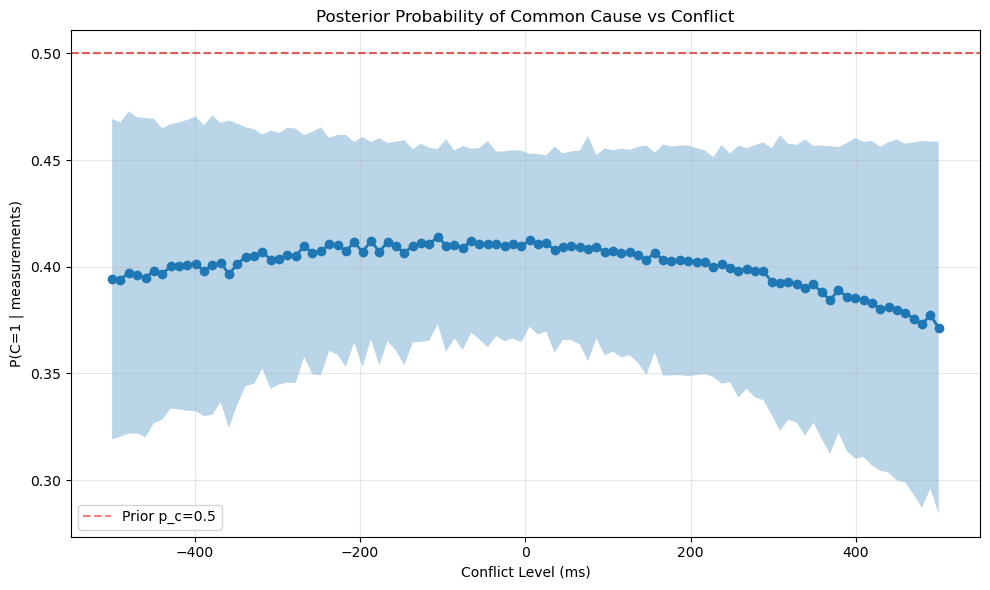

P(C=1) at conflict=0: 0.410
P(C=1) at conflict=±250ms: 0.399, 0.407


In [46]:
# Diagnostic: Plot P(C=1) as a function of conflict
def plot_posterior_vs_conflict(sigma_a=0.5, sigma_v=0.3, p_c=0.5, t_min=0, t_max=1.2, measurement="log-space", nSimul=1000):
    """
    Plot how the posterior probability of common cause changes with conflict level.
    """
    conflicts = np.linspace(-0.5, 0.5, 100)  # Extended range to see full behavior
    posteriors_mean = []
    posteriors_std = []
    
    S_a_s = 0.5  # Standard auditory
    
    for conflict in conflicts:
        S_v_s = S_a_s + conflict  # Visual standard with conflict
        
        # Skip invalid durations
        if measurement == "log-space" and S_v_s <= 0:
            posteriors_mean.append(np.nan)
            posteriors_std.append(np.nan)
            continue
        
        # Generate noisy measurements for standard interval
        if measurement == "log-space":
            m_a_s = np.random.normal(np.log(S_a_s), sigma_a, nSimul)
            m_v_s = np.random.normal(np.log(S_v_s), sigma_v, nSimul)
            t_min_use = np.log(t_min)
            t_max_use = np.log(t_max)
        else:
            m_a_s = np.random.normal(S_a_s, sigma_a, nSimul)
            m_v_s = np.random.normal(S_v_s, sigma_v, nSimul)
            t_min_use = t_min
            t_max_use = t_max
        
        # Calculate posterior for these measurements
        p_C1 = posterior_C1(m_a_s, m_v_s, sigma_a, sigma_v, p_c, t_min_use, t_max_use)
        
        posteriors_mean.append(np.mean(p_C1))
        posteriors_std.append(np.std(p_C1))
    
    posteriors_mean = np.array(posteriors_mean)
    posteriors_std = np.array(posteriors_std)
    
    plt.figure(figsize=(10, 6))
    plt.plot(conflicts * 1000, posteriors_mean, 'o-', linewidth=2, markersize=6)
    plt.fill_between(conflicts * 1000, 
                     posteriors_mean - posteriors_std,
                     posteriors_mean + posteriors_std,
                     alpha=0.3)
    plt.xlabel('Conflict Level (ms)')
    plt.ylabel('P(C=1 | measurements)')
    plt.title('Posterior Probability of Common Cause vs Conflict')
    plt.grid(True, alpha=0.3)
    plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(p_c, color='red', linestyle='--', alpha=0.5, label=f'Prior p_c={p_c}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"P(C=1) at conflict=0: {posteriors_mean[np.argmin(np.abs(conflicts))]:.3f}")
    print(f"P(C=1) at conflict=±250ms: {posteriors_mean[np.argmin(np.abs(conflicts - 0.25))]:.3f}, {posteriors_mean[np.argmin(np.abs(conflicts + 0.25))]:.3f}")

# Test with current parameters
plot_posterior_vs_conflict(sigma_a=0.3, sigma_v=0.3, p_c=0.5, measurement="linear-space")

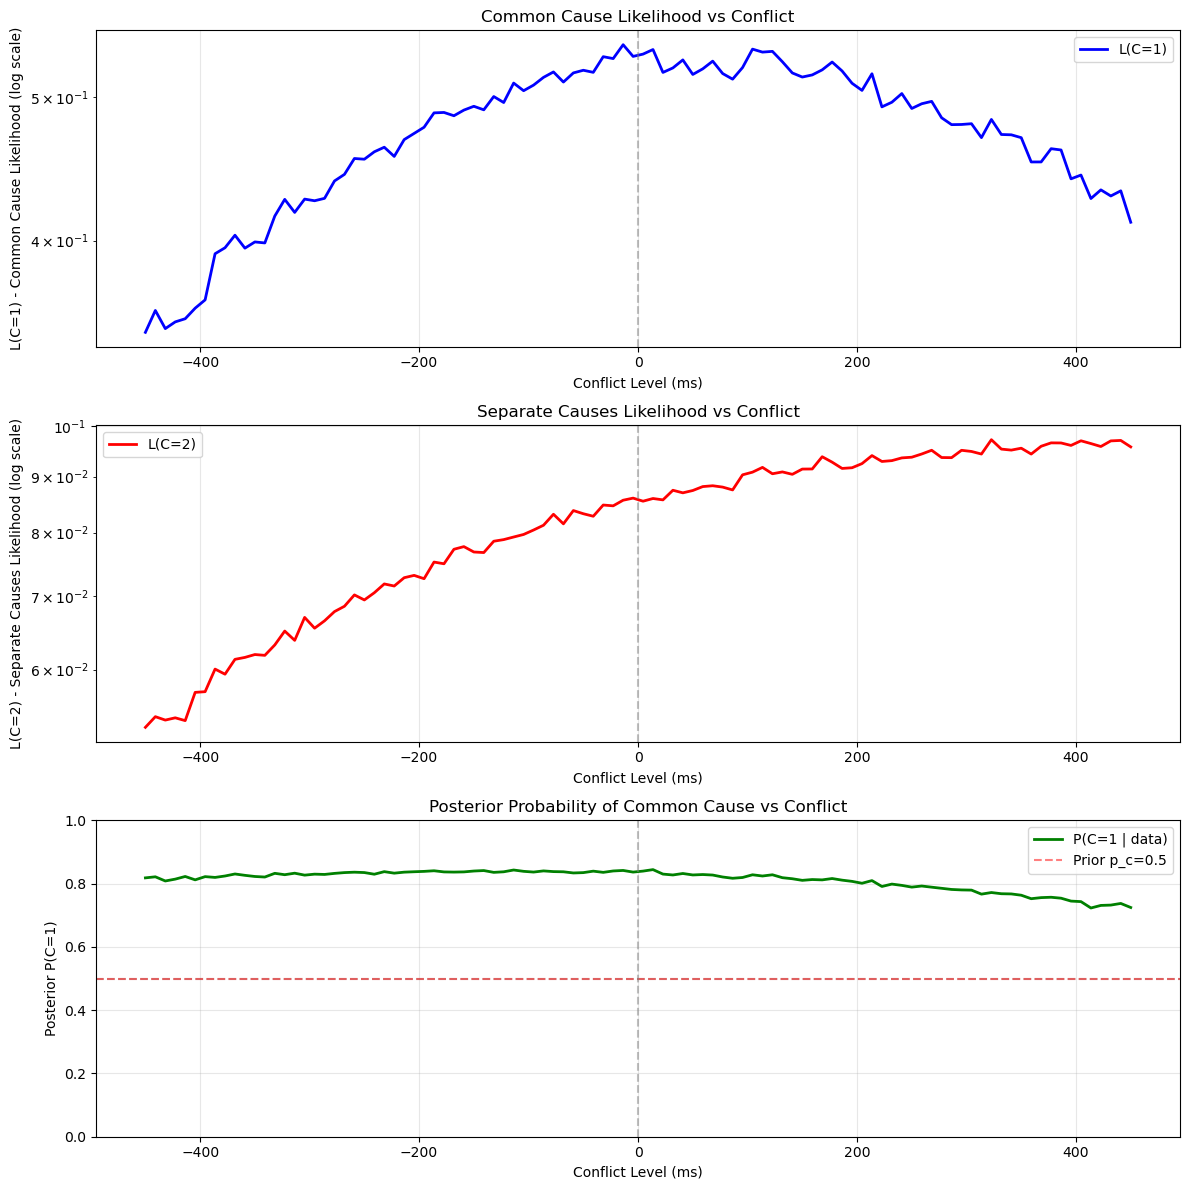


=== Likelihood Analysis ===
At conflict=0ms:
  L(C=1) = 5.35e-01
  L(C=2) = 8.55e-02
  P(C=1) = 0.840

At conflict=-450ms (extreme negative):
  L(C=1) = 3.47e-01
  L(C=2) = 5.31e-02
  P(C=1) = 0.818

At conflict=450ms (extreme positive):
  L(C=1) = 4.12e-01
  L(C=2) = 9.58e-02
  P(C=1) = 0.724


In [47]:
# Diagnostic: Compare L_C1 and L_C2 at extreme conflicts
def plot_likelihood_components(sigma_a=0.3, sigma_v=0.3, p_c=0.5, t_min=0.01, t_max=3.0, measurement="log-space", nSimul=1000):
    """
    Plot L_C1, L_C2, and their ratio across conflict levels to understand asymmetry.
    """
    conflicts = np.linspace(-0.45, 0.45, 100)
    L1_means = []
    L2_means = []
    ratio_means = []
    
    S_a_s = 0.5
    
    for conflict in conflicts:
        S_v_s = S_a_s + conflict
        
        # Skip invalid durations
        if measurement == "log-space" and S_v_s <= 0:
            L1_means.append(np.nan)
            L2_means.append(np.nan)
            ratio_means.append(np.nan)
            continue
        
        # Generate measurements
        if measurement == "log-space":
            m_a_s = np.random.normal(np.log(S_a_s), sigma_a, nSimul)
            m_v_s = np.random.normal(np.log(S_v_s), sigma_v, nSimul)
            t_min_use = np.log(t_min)
            t_max_use = np.log(t_max)
        else:
            m_a_s = np.random.normal(S_a_s, sigma_a, nSimul)
            m_v_s = np.random.normal(S_v_s, sigma_v, nSimul)
            t_min_use = t_min
            t_max_use = t_max
        
        # Calculate likelihoods
        L1 = L_C1(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        L2 = L_C2(m_a_s, m_v_s, sigma_a, sigma_v, t_min_use, t_max_use)
        
        L1_means.append(np.mean(L1))
        L2_means.append(np.mean(L2))
        
        # Calculate ratio (avoid division by zero)
        with np.errstate(divide='ignore', invalid='ignore'):
            ratio = L1 / (L1 + L2)
            ratio_means.append(np.mean(ratio))
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 12))
    
    # Plot 1: L_C1 (Common cause likelihood)
    axes[0].semilogy(np.array(conflicts) * 1000, L1_means, 'b-', linewidth=2, label='L(C=1)')
    axes[0].set_xlabel('Conflict Level (ms)')
    axes[0].set_ylabel('L(C=1) - Common Cause Likelihood (log scale)')
    axes[0].set_title('Common Cause Likelihood vs Conflict')
    axes[0].grid(True, alpha=0.3)
    axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[0].legend()
    
    # Plot 2: L_C2 (Separate causes likelihood)
    axes[1].semilogy(np.array(conflicts) * 1000, L2_means, 'r-', linewidth=2, label='L(C=2)')
    axes[1].set_xlabel('Conflict Level (ms)')
    axes[1].set_ylabel('L(C=2) - Separate Causes Likelihood (log scale)')
    axes[1].set_title('Separate Causes Likelihood vs Conflict')
    axes[1].grid(True, alpha=0.3)
    axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[1].legend()
    
    # Plot 3: Posterior P(C=1) = L1*p_c / (L1*p_c + L2*(1-p_c))
    axes[2].plot(np.array(conflicts) * 1000, ratio_means, 'g-', linewidth=2, label='P(C=1 | data)')
    axes[2].set_xlabel('Conflict Level (ms)')
    axes[2].set_ylabel('Posterior P(C=1)')
    axes[2].set_title('Posterior Probability of Common Cause vs Conflict')
    axes[2].grid(True, alpha=0.3)
    axes[2].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[2].axhline(p_c, color='red', linestyle='--', alpha=0.5, label=f'Prior p_c={p_c}')
    axes[2].axvline(0, color='gray', linestyle='--', alpha=0.5)
    axes[2].set_ylim([0, 1])
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print key values
    zero_idx = np.argmin(np.abs(conflicts))
    neg_extreme_idx = 0
    pos_extreme_idx = -1
    
    print("\n=== Likelihood Analysis ===")
    print(f"At conflict=0ms:")
    print(f"  L(C=1) = {L1_means[zero_idx]:.2e}")
    print(f"  L(C=2) = {L2_means[zero_idx]:.2e}")
    print(f"  P(C=1) = {ratio_means[zero_idx]:.3f}")
    
    print(f"\nAt conflict={conflicts[neg_extreme_idx]*1000:.0f}ms (extreme negative):")
    print(f"  L(C=1) = {L1_means[neg_extreme_idx]:.2e}")
    print(f"  L(C=2) = {L2_means[neg_extreme_idx]:.2e}")
    print(f"  P(C=1) = {ratio_means[neg_extreme_idx]:.3f}")
    
    print(f"\nAt conflict={conflicts[pos_extreme_idx]*1000:.0f}ms (extreme positive):")
    print(f"  L(C=1) = {L1_means[pos_extreme_idx]:.2e}")
    print(f"  L(C=2) = {L2_means[pos_extreme_idx]:.2e}")
    print(f"  P(C=1) = {ratio_means[pos_extreme_idx]:.3f}")

# Run diagnostic
plot_likelihood_components(sigma_a=0.3, sigma_v=0.3, p_c=0.5, measurement="logs-space")

### Understanding the Boundary Effect

The key insight: **Both likelihoods drop towards zero at extreme conflicts, but at different rates.**

At extreme negative conflict (e.g., S_v_s → 0):
- **L_C1** drops because: the exponential term `exp(-(m_a-m_v)²/...)` penalizes the huge discrepancy between m_a and m_v
- **L_C2** drops because: `p_single(m_v, σ_v, t_min, t_max)` becomes tiny when m_v falls far outside the [t_min, t_max] range

The posterior P(C=1) = L_C1/(L_C1 + L_C2) depends on **which likelihood drops faster**.

If L_C2 drops faster than L_C1, then P(C=1) can actually *increase* at extreme conflicts! This creates the asymmetry you're seeing.

## Diagnosis: The Problem with p_single()

The `p_single(m, σ, t_min, t_max)` function should return very small values when measurement `m` is far outside the range [t_min, t_max].

Let's test if it's working correctly:

=== Testing p_single() in log-space ===
Valid range: [-4.61, 1.10] (i.e., [0.01, 3.0]s in linear)
sigma = 0.3

log(0.5) - normal         m=  -0.69  →  p_single = 1.753223e-01
log(0.01) - lower bound   m=  -4.61  →  p_single = 8.766113e-02
log(3.0) - upper bound    m=   1.10  →  p_single = 8.766113e-02
log(0.001) - below range  m=  -6.91  →  p_single = 1.440386e-15
-10 - extreme negative    m= -10.00  →  p_single = 0.000000e+00
log(10) - above range     m=   2.30  →  p_single = 5.250050e-06


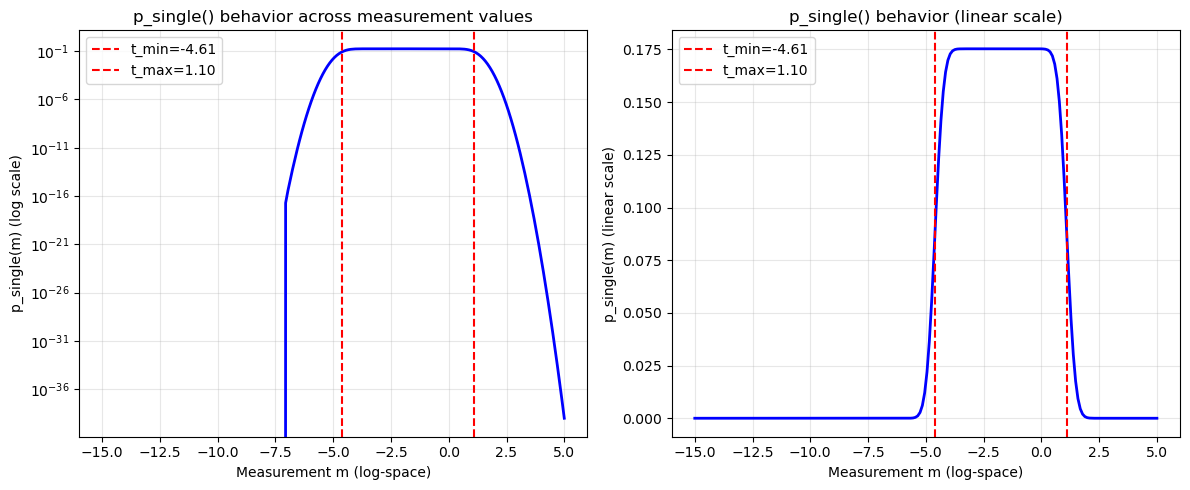

In [48]:
# Test p_single function behavior
def test_p_single():
    """Test if p_single correctly penalizes measurements outside [t_min, t_max]"""
    sigma = 0.3
    t_min_linear = 0.01
    t_max_linear = 3.0
    t_min_log = np.log(t_min_linear)
    t_max_log = np.log(t_max_linear)
    
    # Test measurements at various positions (in log space)
    test_measurements = np.array([
        np.log(0.5),      # Normal: within range
        np.log(0.01),     # At lower boundary
        np.log(3.0),      # At upper boundary
        np.log(0.001),    # Far below range (would be S_v_s ≈ 0 in linear)
        -10,              # Very far below (extreme negative conflict in log space)
        np.log(10.0),     # Far above range
    ])
    
    labels = ['log(0.5) - normal', 'log(0.01) - lower bound', 'log(3.0) - upper bound', 
              'log(0.001) - below range', '-10 - extreme negative', 'log(10) - above range']
    
    print("=== Testing p_single() in log-space ===")
    print(f"Valid range: [{t_min_log:.2f}, {t_max_log:.2f}] (i.e., [{t_min_linear}, {t_max_linear}]s in linear)")
    print(f"sigma = {sigma}\n")
    
    for m, label in zip(test_measurements, labels):
        p = p_single(m, sigma, t_min_log, t_max_log)
        print(f"{label:25} m={m:7.2f}  →  p_single = {p:.6e}")
    
    # Now visualize p_single across a range
    m_range = np.linspace(-15, 5, 200)
    p_values = p_single(m_range, sigma, t_min_log, t_max_log)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.semilogy(m_range, p_values, 'b-', linewidth=2)
    plt.axvline(t_min_log, color='red', linestyle='--', label=f't_min={t_min_log:.2f}')
    plt.axvline(t_max_log, color='red', linestyle='--', label=f't_max={t_max_log:.2f}')
    plt.xlabel('Measurement m (log-space)')
    plt.ylabel('p_single(m) (log scale)')
    plt.title('p_single() behavior across measurement values')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(m_range, p_values, 'b-', linewidth=2)
    plt.axvline(t_min_log, color='red', linestyle='--', label=f't_min={t_min_log:.2f}')
    plt.axvline(t_max_log, color='red', linestyle='--', label=f't_max={t_max_log:.2f}')
    plt.xlabel('Measurement m (log-space)')
    plt.ylabel('p_single(m) (linear scale)')
    plt.title('p_single() behavior (linear scale)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

test_p_single()